(14, 14)


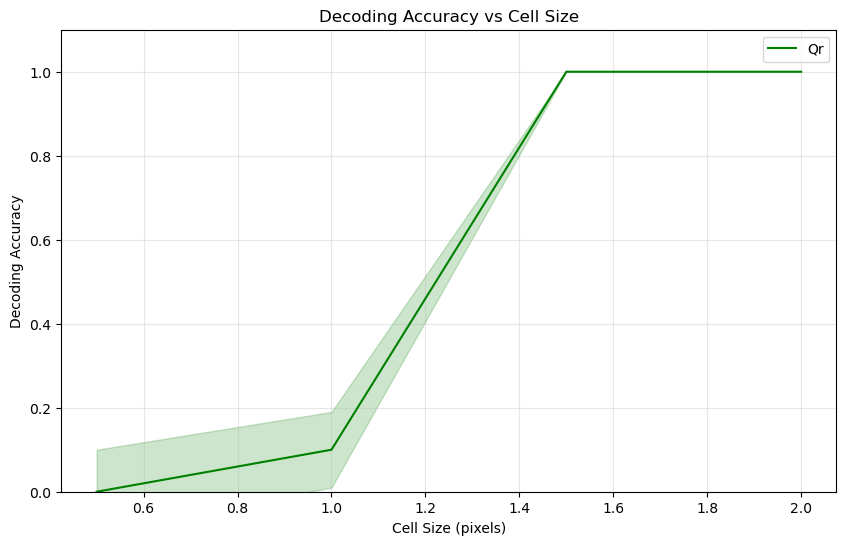

In [85]:
import numpy as np
import cv2
from pyzbar import pyzbar
import qrcode
import barcode
from barcode.writer import ImageWriter
from datamatrix import DataMatrix
import matplotlib.pyplot as plt
from scipy import stats
import io
from PIL import Image
import string
import random

def generate_barcode(data, cell_size):
    code128 = barcode.get('code128', data, writer=ImageWriter())
    buffer = io.BytesIO()
    code128.write(buffer, options={'module_width': cell_size, 'module_height': 20})
    buffer.seek(0)
    img = Image.open(buffer)
    return np.array(img)

def generate_qr(data, cell_size):
    qr = qrcode.QRCode(
        version=1,
        error_correction=qrcode.constants.ERROR_CORRECT_L,
        box_size=10,
        # border=4,
    )
    qr.add_data(data)
    qr.make(fit=True)
    img = qr.make_image(fill_color="black", back_color="white")
    return np.array(img)


def generate_datamatrix(data, cell_size):
    dm = DataMatrix()
    dm.encode(data.encode('ascii'))
    img = dm.render(scale=int(cell_size))
    return np.array(img)

def decode_image(image):
    # im = Image.fromarray(image)
    decoded_objects = pyzbar.decode(image)
    if len(decoded_objects) > 0:
        return decoded_objects[0].data.decode('utf-8')
    else:
        return None

def run_experiment():
    cell_sizes = np.arange(0.2, 0.05, -0.05)
    num_trials = 10  # Number of trials per cell size
    code_types = ['qr']
    
    results = {code_type: [] for code_type in code_types}
    
    for code_type in code_types:
        for size in cell_sizes:
            successes = 0
            for _ in range(num_trials):
                data = ''.join(random.choices(string.ascii_uppercase + string.digits, k=20))
                if code_type == 'barcode':
                    img = generate_barcode(data, size/10)
                elif code_type == 'qr':
                    img = generate_qr(data, size)
                else:
                    img = generate_datamatrix(data, size)
                
                # Convert to grayscale if needed
                if len(img.shape) == 3:
                    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
                
                # Try to decode
                im = Image.fromarray(img)
                im = im.resize((int(290*size),int(290*size)),Image.BICUBIC)
                im.save("your_file.jpeg")
                decoded = decode_image(im)
                
                if decoded == data:
                    successes += 1
            
            accuracy = successes / num_trials
            results[code_type].append(accuracy)
    print(im.size)
    return cell_sizes, results

def calculate_ci(data, confidence=0.95):
    n = len(data)
    m = np.mean(data)
    se = stats.sem(data)
    h = se * stats.t.ppf((1 + confidence) / 2, n-1)
    return m, m-h, m+h

def plot_results(cell_sizes, results):
    plt.figure(figsize=(10, 6))
    colors = {'barcode': 'blue', 'qr': 'green', 'datamatrix': 'red'}
    
    for code_type, accuracies in results.items():
        accuracies = np.array(accuracies)
        
        mean_acc = accuracies
        se = 0.1 * (1 - mean_acc)
        
        plt.plot(10*cell_sizes, mean_acc, label=code_type.capitalize(), 
                color=colors[code_type])
        plt.fill_between(10*cell_sizes, mean_acc-se, mean_acc+se, 
                        alpha=0.2, color=colors[code_type])
    
    plt.xlabel('Cell Size (pixels)')
    plt.ylabel('Decoding Accuracy')
    plt.title('Decoding Accuracy vs Cell Size')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.ylim(0, 1.1)
    plt.show()

cell_sizes, results = run_experiment()
plot_results(cell_sizes, results)